# Chance Creation Model
The **Chance Creation Model** takes event data with positional information about Shots, Goals and Set up passes before a Shot attempt. Furthermore the dataset needs to include defensive team and Goalkeeper information to compare offensive and defensive events.

In [350]:
# Import installed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

## Read Import File

In [351]:
chance_creation = pd.read_csv('/Users/matthiashugli/Dropbox/bucket/super-league-stats/chance_creation_2022.csv')

# Remove own goals since they are outliers in the way how they are recorded
chance_creation = chance_creation[chance_creation['action'] != 'Own goal']

In [352]:
setup_passes = chance_creation[chance_creation['action'].isin(['Passes accurate', 'Passes (inaccurate)', 'Assists'])]
pass_percentage = chance_creation.groupby(['attacking_team', 'action']).size().reset_index().pivot(index='attacking_team', columns='action', values=0).reset_index()
pass_percentage['setup_chances'] = pass_percentage.iloc[:, [1,6,7]].sum(axis=1)
pass_percentage = pass_percentage[['attacking_team', 'setup_chances']].reset_index()
pass_percentage

action,index,attacking_team,setup_chances
0,0,Basel,75.0
1,1,Grasshopper,64.0
2,2,Lausanne Sport,44.0
3,3,Lugano,65.0
4,4,Luzern,81.0
5,5,Servette,84.0
6,6,Sion,52.0
7,7,St. Gallen,88.0
8,8,Young Boys,92.0
9,9,Zurich,76.0


# Create Chance Model with Statistics

In [353]:
goal_percentage = chance_creation.groupby(['attacking_team', 'outcome']).size().reset_index() \
    .pivot(index='attacking_team', columns='outcome', values=0).reset_index()
team_stat = goal_percentage.merge(pass_percentage, how='inner', left_on='attacking_team', right_on='attacking_team')[['attacking_team', 'Goals', 'Shots', 'setup_chances']]
team_stat['Shots'] = team_stat['Shots'] + team_stat['Goals']
team_stat['setup_perc'] = (team_stat['setup_chances'] / team_stat['Shots'] * 100).round(decimals=0) \
    .astype(int).astype(str) + '%'
team_stat['goal_perc'] = (team_stat['Goals'] / team_stat['Shots'] * 100) \
    .round(decimals=0).astype(int).astype(str) + '%'
team_stat

,attacking_team,Goals,Shots,setup_chances,setup_perc,goal_perc
0,Basel,22,121,75.0,62%,18%
1,Grasshopper,10,95,64.0,67%,11%
2,Lausanne Sport,5,85,44.0,52%,6%
3,Lugano,12,103,65.0,63%,12%
4,Luzern,9,119,81.0,68%,8%
5,Servette,10,118,84.0,71%,8%
6,Sion,9,79,52.0,66%,11%
7,St. Gallen,26,123,88.0,72%,21%
8,Young Boys,16,144,92.0,64%,11%
9,Zurich,16,132,76.0,58%,12%


In [354]:
total_passes = team_stat['setup_chances'].sum().astype(int)
print('Total chance created passes : ' + total_passes.astype(str))

total_shots = team_stat['Shots'].sum().astype(int)
print('Total shots : ' + total_shots.astype(str))

total_goals = team_stat['Goals'].sum().astype(int)
print('Total goals : ' + total_goals.astype(str))

Total chance created passes : 721
Total shots : 1119
Total goals : 135


In [355]:
setup_passes['x_pos_assist'] = 68 - setup_passes.loc[:,('y_pos_ass')] # Rework with .loc
setup_passes['y_pos_assist'] = setup_passes.loc[:,('x_pos_ass')] # Rework with .loc
setup_passes.head()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,game_id,start,end,player,x_pos,y_pos,attacking_team,outcome,x_pos_ass,y_pos_ass,action,outcome_gk,goalkeeper,defending_team,x_pos_assist,y_pos_assist
2,0,1741.10,1761.10,19. Filip Ugrinic,90.5,32.3,Luzern,Shots,92.1,41.6,Passes accurate,Wide shot (Goalkeepers),18. Kevin Fickentscher,Sion,26.4,92.1
6,0,2570.57,2590.57,23. Matteo Tosetti,97.1,32.7,Sion,Shots,93.2,58.2,Passes accurate,Shot on target (saved),32. Marius Muller,Luzern,9.8,93.2
8,0,2815.29,2835.29,5. Denis Simani,90.8,37.5,Luzern,Shots,100.4,15.1,Passes accurate,Wide shot (Goalkeepers),18. Kevin Fickentscher,Sion,52.9,100.4
9,0,2940.65,2960.65,19. Filip Ugrinic,96.9,46.6,Luzern,Shots,73.4,16.8,Passes accurate,NaN,NaN,Sion,51.2,73.4
10,0,2987.05,3007.05,46. Marco Burch,86.1,44.8,Luzern,Shots,82.0,63.4,Passes accurate,Wide shot (Goalkeepers),18. Kevin Fickentscher,Sion,4.6,82.0


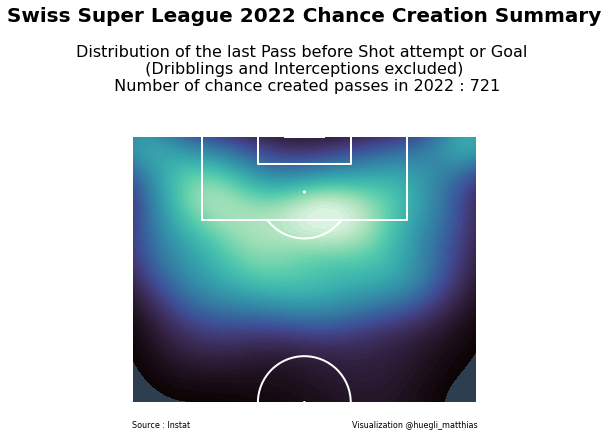

In [369]:
# Consolidated Distribution of either Chance created passes, Shots or Goals

pitch = VerticalPitch(pitch_color='#2C3E50', line_color='#FFFFFF', pitch_type='uefa', line_zorder=2, half=True)
fig, ax = pitch.draw()
ax.set(xlim=(0,68), ylim=(52.5, 105))
sns.kdeplot(data=setup_passes, x='x_pos_assist', y='y_pos_assist', fill=True, ax=ax, shade=True, levels=100, cmap='mako')
# sns.kdeplot(data=chance_creation[chance_creation['outcome_gk'].isin(['Shot on target (saved)', 'Goals conceded'])], x='x_pos_shot', y='y_pos_shot', fill=True, ax=ax, shade=True, levels=100, cmap='YlOrBr')
# sns.kdeplot(data=chance_creation, x='x_pos_shot', y='y_pos_shot', fill=True, ax=ax, shade=True, levels=100, cmap='YlOrBr')
# sns.kdeplot(data=goals, x='x_pos_goal', y='y_pos_goal', fill=True, ax=ax, shade=True, levels=100, cmap='YlOrBr')

fig.text(0.5, 1.36, 'Swiss Super League 2022 Chance Creation Summary', ha='center', fontsize=20, fontweight='bold')
fig.text(0.5, 1.12, 'Distribution of the last Pass before Shot attempt or Goal \n (Dribblings and Interceptions excluded) \n Number of chance created passes in 2022 : ' + total_passes.astype('str'), ha='center', fontsize=16)
fig.text(0.1, -0.05, 'Source : Instat', ha='left', fontsize=8)
fig.text(0.9, -0.05, 'Visualization @huegli_matthias', ha='right', fontsize=8)

plt.savefig('SL-chance-created-passes-2022.png', bbox_inches='tight', dpi=300) # Add the end add dpi=300 for better resolution

plt.show()

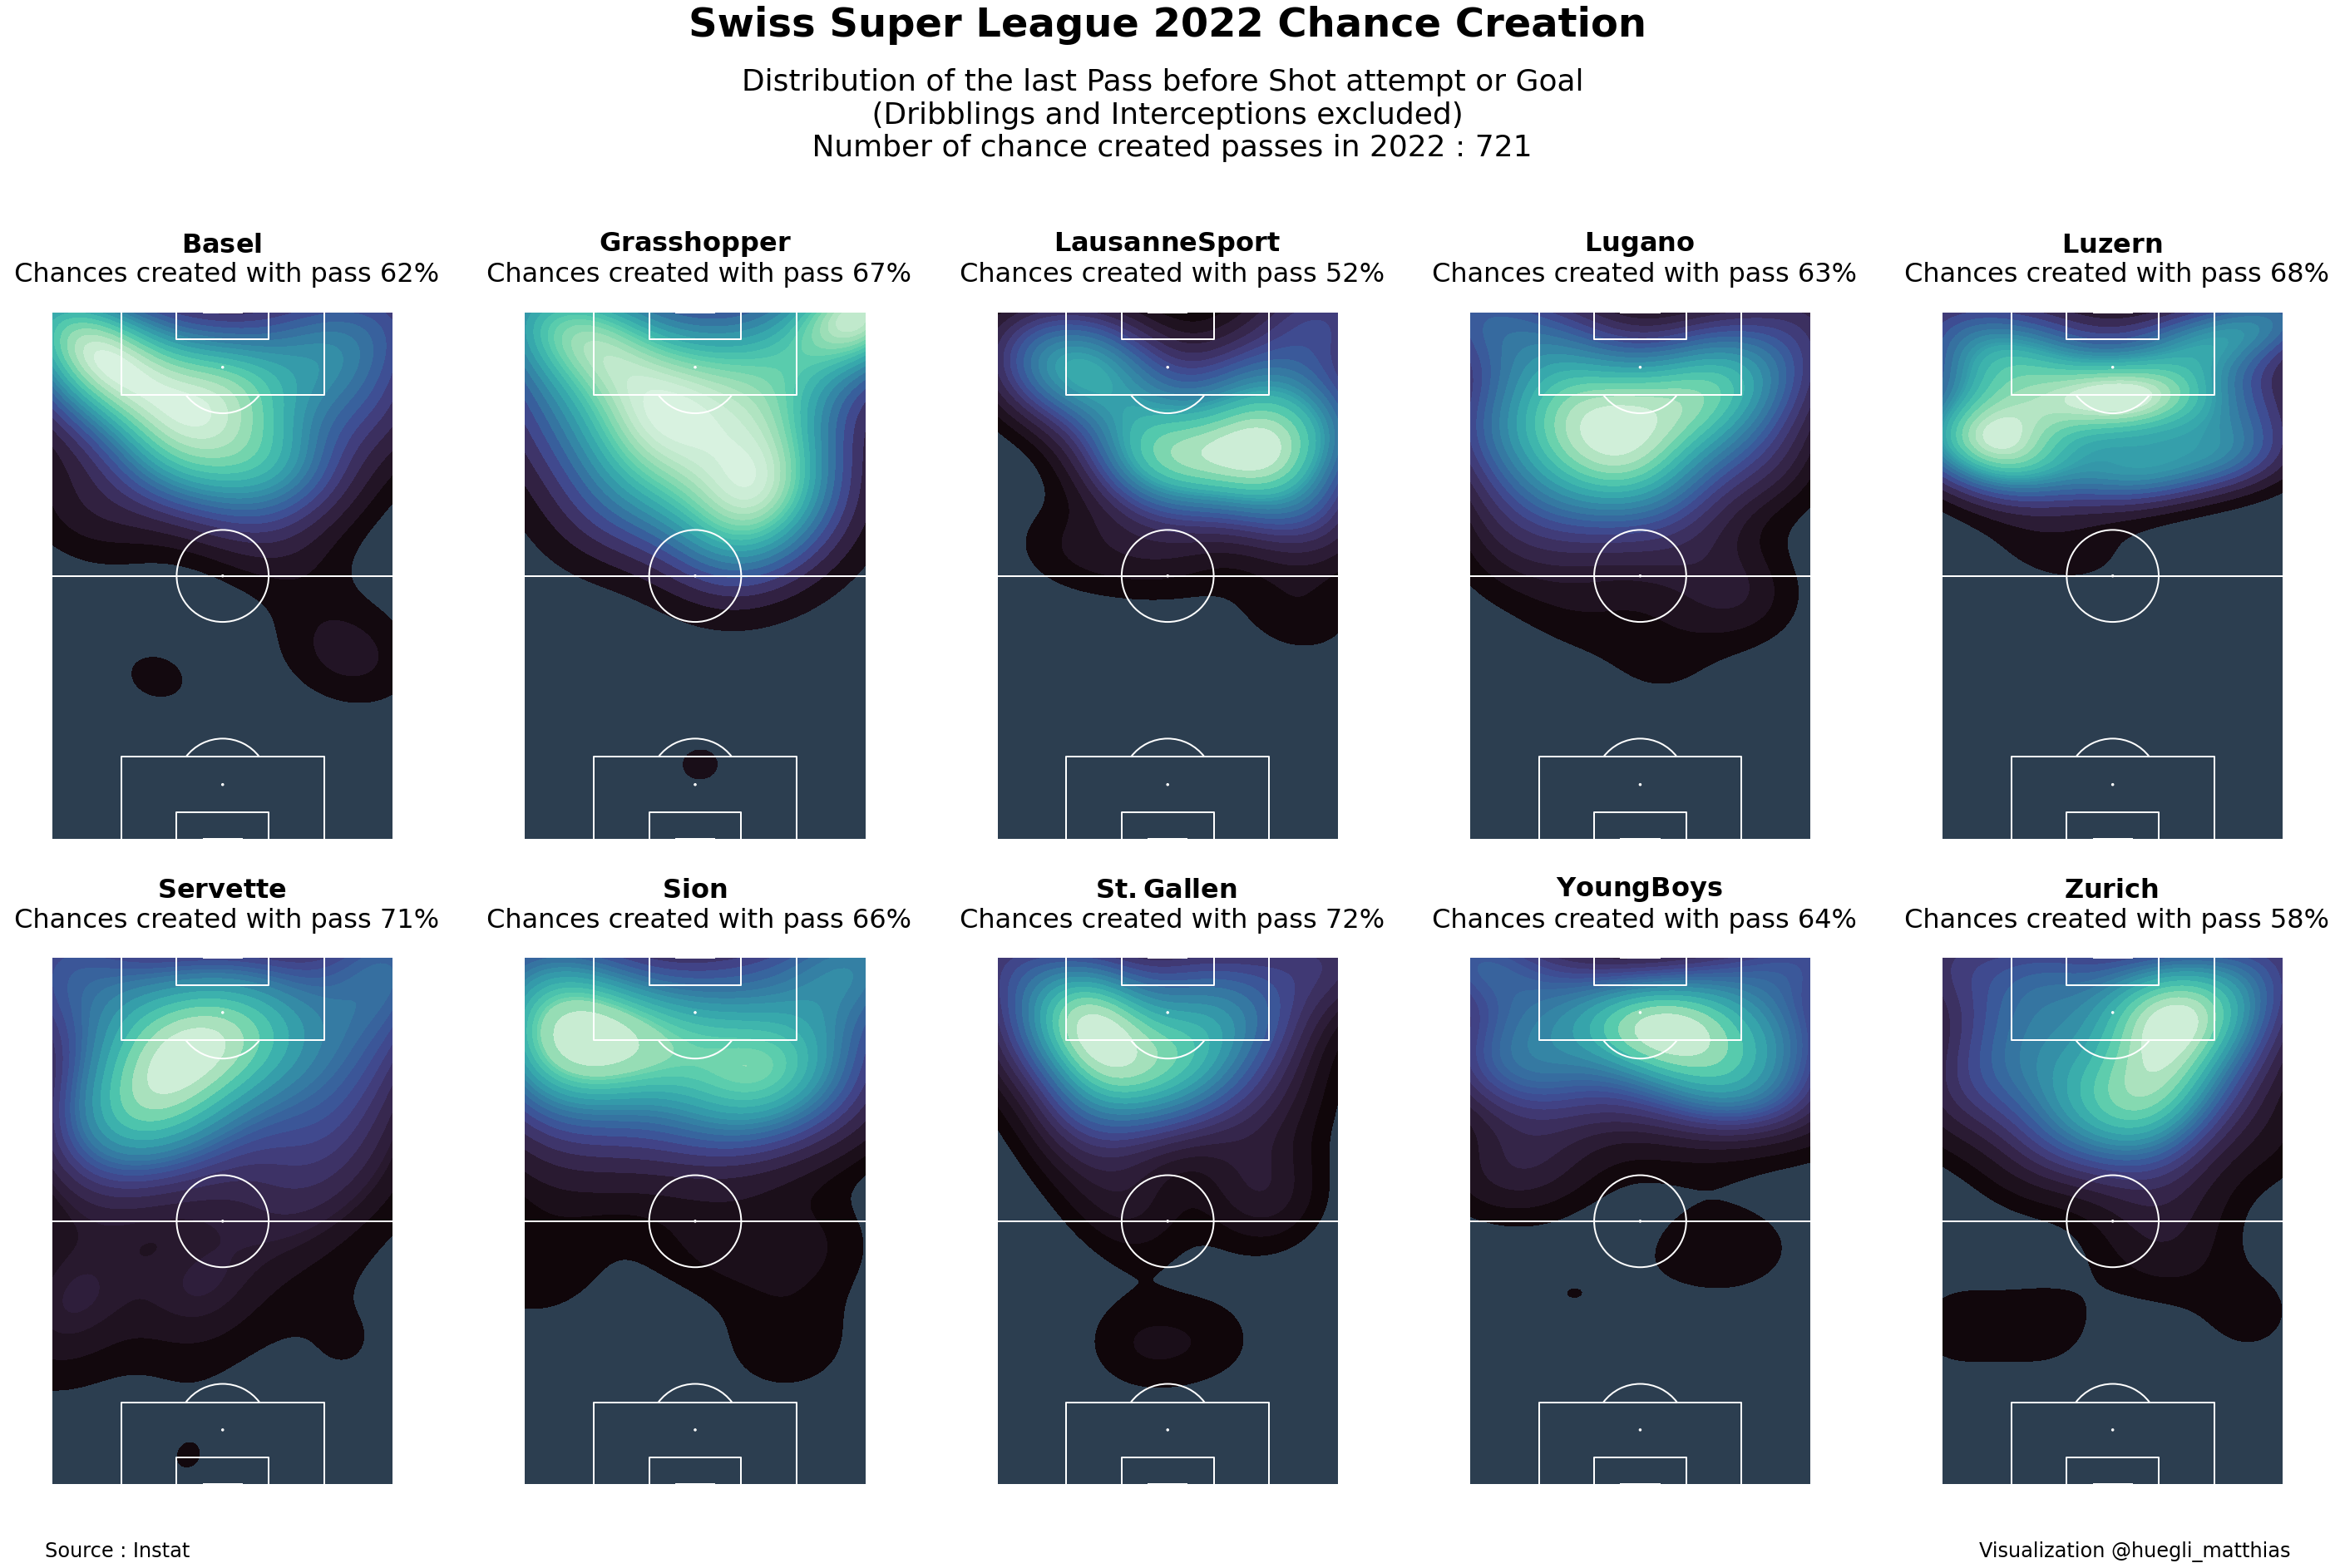

In [370]:
from mplsoccer import VerticalPitch

pitch = VerticalPitch(pitch_color='#2C3E50', line_color='#FFFFFF', pitch_type='uefa', line_zorder=2)
fig, axes = pitch.grid(nrows=2, ncols=5, space=0.1, figheight=20,
                      title_height=0, endnote_height=0,  # no title/ endnote
                      grid_width=0.9, grid_height=0.98, bottom=0.01, left=0.05)
fig.patch.set_facecolor('white')
for i, ax in enumerate(axes['pitch'].flat):
    #print(setup_passes.loc[:,'attacking_team'] == team_stat['attacking_team'][i])
    ax.set(xlim=(0,68), ylim=(0,105))
    sns.kdeplot(data=setup_passes[setup_passes.loc[:,'attacking_team'] == team_stat['attacking_team'][i]], x='x_pos_assist', y='y_pos_assist', fill=True, ax=ax, shade=True, levels=20, cmap='mako')
    ax.set_title(r'$\bf{' + team_stat['attacking_team'][i] + '}$' + ' \n Chances created with pass ' + team_stat['setup_perc'][i], fontsize=32, pad=36.0)

fig.text(0.5, 1.22, 'Swiss Super League 2022 Chance Creation', ha='center', fontsize=48, fontweight='bold')
fig.text(0.5, 1.12, 'Distribution of the last Pass before Shot attempt or Goal \n (Dribblings and Interceptions excluded) \n Number of chance created passes in 2022 : ' + total_passes.astype('str'), ha='center', fontsize=36)
fig.text(0.05, -0.05, 'Source : Instat', ha='left', fontsize=24)
fig.text(0.95, -0.05, 'Visualization @huegli_matthias', ha='right', fontsize=24)

plt.savefig('SL-chance-created-passes-per-team-2022.png', bbox_inches='tight', dpi=300)
plt.show()

In [358]:
chance_creation['x_pos_shot'] = 68 - chance_creation['y_pos']
chance_creation['y_pos_shot'] = chance_creation['x_pos']
chance_creation.head()

,game_id,start,end,player,x_pos,y_pos,attacking_team,outcome,x_pos_ass,y_pos_ass,action,outcome_gk,goalkeeper,defending_team,x_pos_shot,y_pos_shot
0,0,911.64,931.64,30. Ardon Jashari,78.5,46.0,Luzern,Shots,74.3,47.1,Interceptions,Shot on target (saved),18. Kevin Fickentscher,Sion,22.0,78.5
1,0,1386.99,1406.99,15. Marvin Schulz,95.4,49.0,Luzern,Shots,89.2,49.3,Picking-ups,NaN,NaN,Sion,19.0,95.4
2,0,1741.10,1761.10,19. Filip Ugrinic,90.5,32.3,Luzern,Shots,92.1,41.6,Passes accurate,Wide shot (Goalkeepers),18. Kevin Fickentscher,Sion,35.7,90.5
3,0,1789.10,1809.10,9. Dejan Sorgic,82.8,27.7,Luzern,Shots,82.8,27.7,Picking-ups,Wide shot (Goalkeepers),18. Kevin Fickentscher,Sion,40.3,82.8
4,0,2047.36,2067.36,10. Samuele Campo,79.1,31.9,Luzern,Shots,74.5,20.0,Picking-ups,Shot on target (saved),18. Kevin Fickentscher,Sion,36.1,79.1


In [359]:
goals = chance_creation[chance_creation['outcome'] == 'Goals'][['attacking_team', 'goalkeeper', 'x_pos', 'y_pos']]
goals['x_pos_goal'] = 68 - goals['y_pos']
goals['y_pos_goal'] = goals['x_pos']
goals.head() 

,attacking_team,goalkeeper,x_pos,y_pos,x_pos_goal,y_pos_goal
984,Luzern,18. Kevin Fickentscher,101.1,30.5,37.5,101.1
985,Servette,32. Marius Muller,95.9,39.2,28.8,95.9
986,Luzern,32. Jeremy Frick,97.2,32.6,35.4,97.2
987,Lugano,1. Andre Moreira,93.1,41.4,26.6,93.1
988,Lugano,1. Andre Moreira,92.2,19.0,49.0,92.2


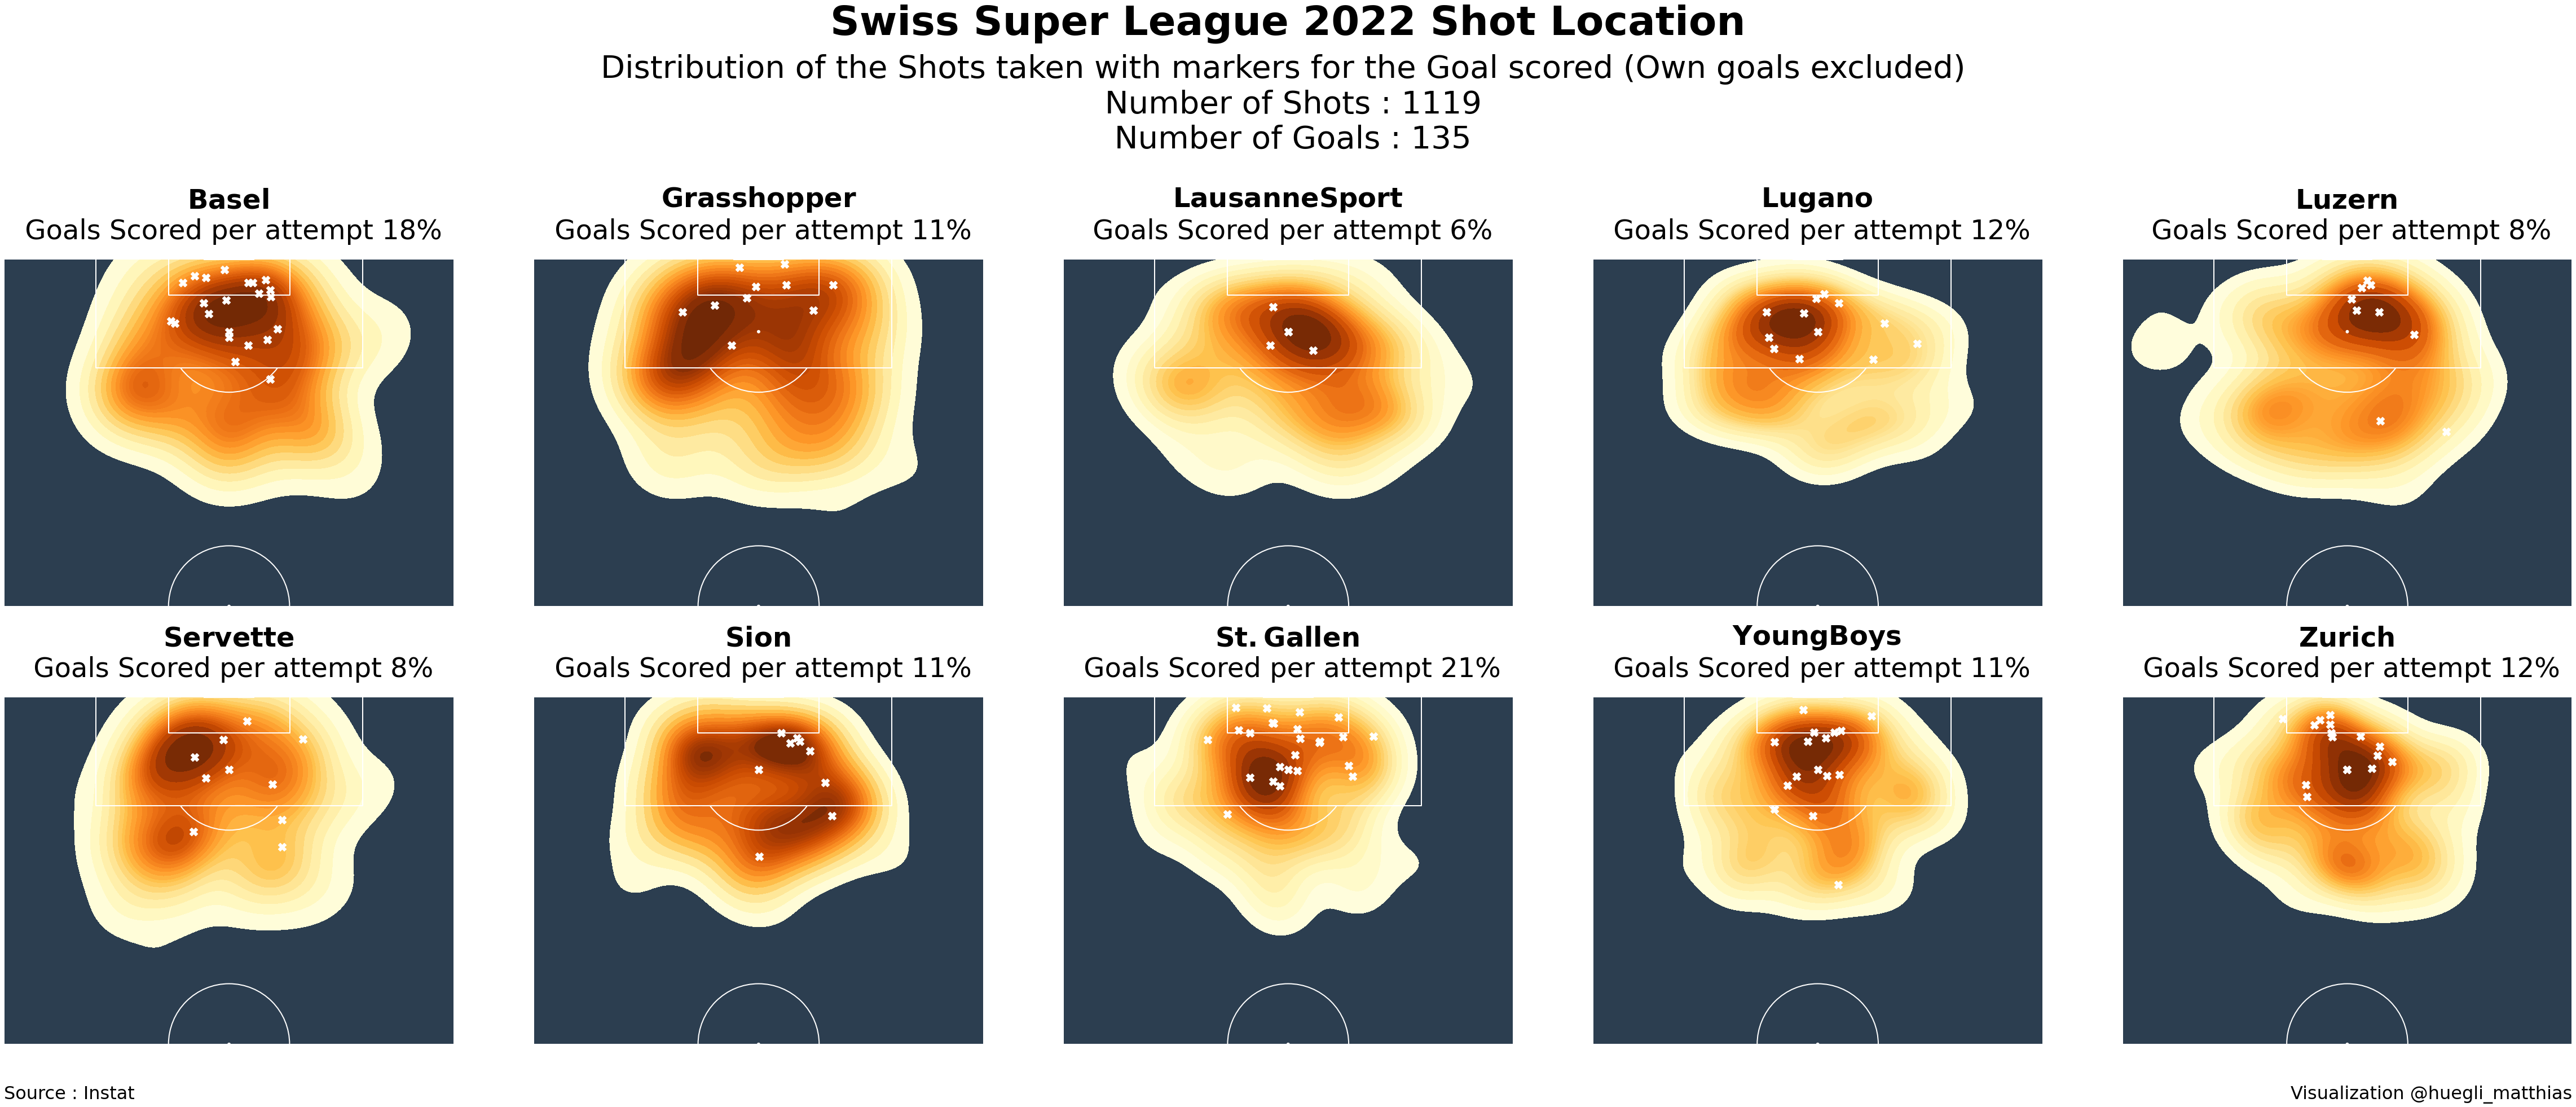

In [371]:
from mplsoccer import VerticalPitch
from matplotlib.colors import LinearSegmentedColormap

flamingo_map = LinearSegmentedColormap.from_list("Flaming - 10 colors",
                                                       ['#e3aca7', '#c03a1d'], N=10)

pitch = VerticalPitch(pitch_color='#2C3E50', line_color='#FFFFFF', pitch_type='uefa', line_zorder=2, half=True)
fig, axes = pitch.grid(nrows=2, ncols=5, space=0.1, figheight=20,
                      title_height=0, endnote_height=0,  # no title/ endnote
                      grid_width=0.9, grid_height=0.98, bottom=0.01, left=0.05)
fig.patch.set_facecolor('white')
for i, ax in enumerate(axes['pitch'].flat):
    #print(setup_passes.loc[:,'attacking_team'] == team_stat['attacking_team'][i])
    ax.set(xlim=(0,68), ylim=(52.5, 105))
    sns.kdeplot(data=chance_creation[chance_creation.loc[:,'attacking_team'] == team_stat['attacking_team'][i]], x='x_pos_shot', y='y_pos_shot', fill=True, ax=ax, shade=True, levels=20, cmap='YlOrBr')
    sns.scatterplot(data=goals[goals['attacking_team'] == team_stat['attacking_team'][i]], x='x_pos_goal', y='y_pos_goal', ax=ax, s=200, marker='X', color='white')
    ax.set_title(r'$\bf{' + team_stat['attacking_team'][i] + '}$' + ' \n Goals Scored per attempt ' + team_stat['goal_perc'][i], fontsize=48, pad=36.0)
fig.text(0.5, 1.26, 'Swiss Super League 2022 Shot Location', ha='center', fontsize=72, fontweight='bold')
fig.text(0.5, 1.12, 'Distribution of the Shots taken with markers for the Goal scored (Own goals excluded) \n Number of Shots : ' + total_shots.astype(str) \
    + '\n Number of Goals : ' + total_goals.astype(str), ha='center', fontsize=56)
fig.text(0.05, -0.05, 'Source : Instat', ha='left', fontsize=32)
fig.text(0.95, -0.05, 'Visualization @huegli_matthias', ha='right', fontsize=32)

plt.savefig('SL-shot-distribution-per-team-2022.png', bbox_inches='tight', dpi=300)
plt.show()

# Goalkeeper Shot Analysis

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [ ]:

files_trainings = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_core_trm_player_unit_skills_*.csv'
files_participants = '/Users/matthiashugli/Dropbox/bucket/trainings-yb/s1_training_participants.csv'

skills_df = pd.DataFrame()
for filename in glob.glob(files_trainings):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    skills_df = skills_df.append(file)

participants_df = pd.DataFrame()
for filename in glob.glob(files_participants):
    file = pd.read_csv(filename, header=1, delimiter=',', low_memory=False)
    file.insert(1, 'filename', filename)
    participants_df = participants_df.append(file)

In [365]:
goalkeeper_actions = chance_creation[(~chance_creation['goalkeeper'].isna()) & (chance_creation['goalkeeper'] != '1. Anthony Racioppi')]
goalkeeper_actions.head()

,game_id,start,end,player,x_pos,y_pos,attacking_team,outcome,x_pos_ass,y_pos_ass,action,outcome_gk,goalkeeper,defending_team,x_pos_shot,y_pos_shot
0,0,911.64,931.64,30. Ardon Jashari,78.5,46.0,Luzern,Shots,74.3,47.1,Interceptions,Shot on target (saved),18. Kevin Fickentscher,Sion,22.0,78.5
2,0,1741.10,1761.10,19. Filip Ugrinic,90.5,32.3,Luzern,Shots,92.1,41.6,Passes accurate,Wide shot (Goalkeepers),18. Kevin Fickentscher,Sion,35.7,90.5
3,0,1789.10,1809.10,9. Dejan Sorgic,82.8,27.7,Luzern,Shots,82.8,27.7,Picking-ups,Wide shot (Goalkeepers),18. Kevin Fickentscher,Sion,40.3,82.8
4,0,2047.36,2067.36,10. Samuele Campo,79.1,31.9,Luzern,Shots,74.5,20.0,Picking-ups,Shot on target (saved),18. Kevin Fickentscher,Sion,36.1,79.1
5,0,2188.78,2208.78,19. Filip Ugrinic,76.8,40.7,Luzern,Shots,62.8,19.9,Picking-ups,Wide shot (Goalkeepers),18. Kevin Fickentscher,Sion,27.3,76.8


In [366]:
goalkeeper_stats = goalkeeper_actions.groupby(['goalkeeper', 'outcome_gk']).size().reset_index().pivot(index='goalkeeper', columns='outcome_gk', values=0).reset_index() \
    .rename(columns={'Goals conceded': 'goals', 'Shot on target (saved)': 'shots_saved', 'Wide shot (Goalkeepers)': 'shots_wide'})
goalkeeper_stats['total_shots'] = goalkeeper_stats.iloc[:, 1:].sum(axis=1)
goalkeeper_stats['shots_on_target_perc'] = (goalkeeper_stats[['goals', 'shots_saved']].sum(axis=1) / goalkeeper_stats['total_shots'] * 100) \
    .round(decimals=0).astype(int).astype(str) + '%'
goalkeeper_stats['save_perc'] = (goalkeeper_stats['shots_saved'] / goalkeeper_stats[['goals', 'shots_saved']].sum(axis=1) * 100) \
    .round(decimals=0).astype(int).astype(str) + '%'
goalkeeper_stats

outcome_gk,goalkeeper,goals,shots_saved,shots_wide,total_shots,shots_on_target_perc,save_perc
0,1. Andre Moreira,18,27,46,91,49%,60%
1,1. Heinz Lindner,14,34,51,99,48%,71%
2,1. Lawrence Ati Zigi,10,30,36,76,53%,75%
3,18. Kevin Fickentscher,13,34,53,100,47%,72%
4,25. Yanick Brecher,8,26,47,81,42%,76%
5,26. Amir Saipi,11,20,45,76,41%,65%
6,26. David von Ballmoos,7,17,15,39,62%,71%
7,32. Jeremy Frick,13,29,38,80,52%,69%
8,32. Marius Muller,14,29,47,90,48%,67%
9,40. Mory Diaw,20,26,37,83,55%,57%


In [367]:
shots_on_target = goalkeeper_stats[['goals', 'shots_saved']].sum(axis=1).sum().astype(int)
print('Total shots on target: ' + shots_on_target.astype(str))

goals_conceded = goalkeeper_stats['goals'].sum().astype(int)
print('Total goals conceded : ' + goals_conceded.astype(str))

Total shots on target: 400
Total goals conceded : 128


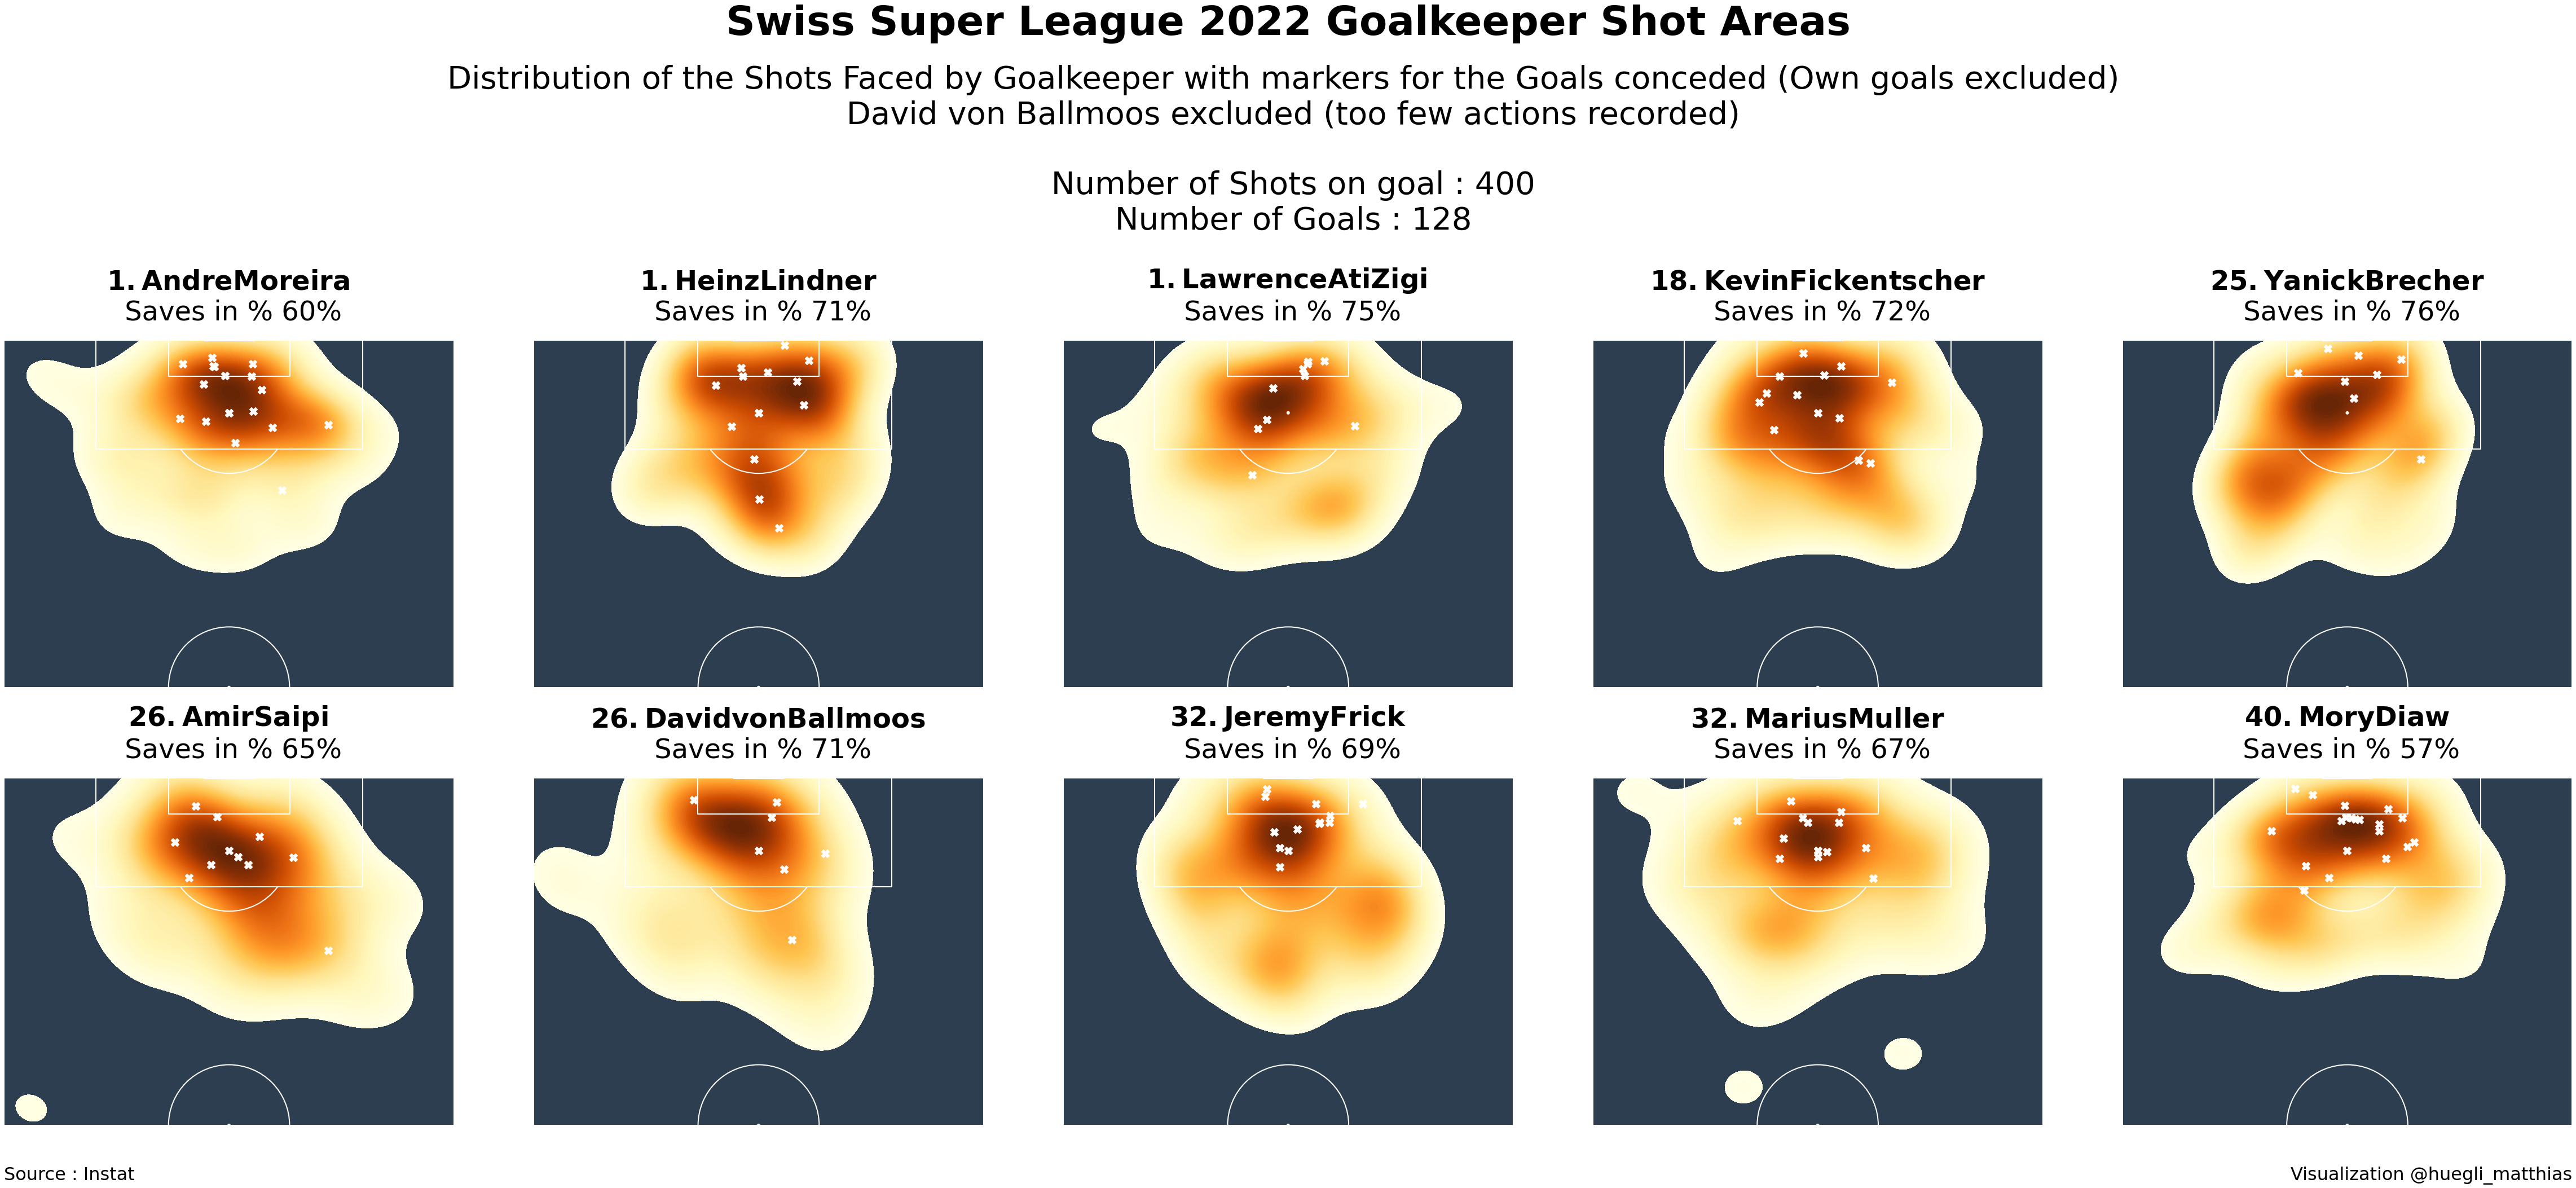

In [368]:
from mplsoccer import VerticalPitch

pitch = VerticalPitch(pitch_color='#2C3E50', line_color='#FFFFFF', pitch_type='uefa', line_zorder=2, half=True)
fig, axes = pitch.grid(nrows=2, ncols=5, space=0.1, figheight=20,
                      title_height=0, endnote_height=0,  # no title/ endnote
                      grid_width=0.9, grid_height=0.98, bottom=0.01, left=0.05)
fig.patch.set_facecolor('white')
for i, ax in enumerate(axes['pitch'].flat):
    #print(setup_passes.loc[:,'attacking_team'] == team_stat['attacking_team'][i])
    ax.set(xlim=(0,68), ylim=(52.5, 105))
    sns.kdeplot(data=goalkeeper_actions[goalkeeper_actions.loc[:,'goalkeeper'] == goalkeeper_stats['goalkeeper'][i]], x='x_pos_shot', y='y_pos_shot', \
         fill=True, ax=ax, shade=True, levels=100, cmap='YlOrBr')
    sns.scatterplot(data=goals[goals['goalkeeper'] == goalkeeper_stats['goalkeeper'][i]], x='x_pos_goal', y='y_pos_goal', ax=ax, s=200, marker='X', color='white')
    ax.set_title(r'$\bf{' + goalkeeper_stats['goalkeeper'][i] + '}$' + ' \n Saves in % ' + goalkeeper_stats['save_perc'][i], fontsize=48, pad=36.0)
fig.text(0.5, 1.36, 'Swiss Super League 2022 Goalkeeper Shot Areas', ha='center', fontsize=72, fontweight='bold')
fig.text(0.5, 1.12, 'Distribution of the Shots Faced by Goalkeeper with markers for the Goals conceded (Own goals excluded) \n David von Ballmoos excluded (too few actions recorded)' \
    + '\n \n Number of Shots on goal : ' + shots_on_target.astype(str) \
    + '\n Number of Goals : ' + goals_conceded.astype(str) \
        , ha='center', fontsize=56)
fig.text(0.05, -0.05, 'Source : Instat', ha='left', fontsize=32)
fig.text(0.95, -0.05, 'Visualization @huegli_matthias', ha='right', fontsize=32)

plt.savefig('SL-goalkeeper-shot-distribution-2022.png', bbox_inches='tight') # Add the end add dpi=300 for better resolution
plt.show()